# Notebook 3: PyTorch Dataset & DataLoader

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image
import json
import matplotlib.pyplot as plt

# Albumentations for augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.8.0
CUDA available: False


In [2]:
# Paths
DATA_DIR = Path("data")
OUTPUT_DIR = Path("outputs")

# Image settings
IMG_SIZE = 192 #224  # Standard for most pre-trained models
BATCH_SIZE = 64 #32
NUM_WORKERS = 0  # Adjust based on your CPU

# Class names
CLASS_COLUMNS = [
    'antelope_duiker', 'bird', 'blank', 'civet_genet',
    'hog', 'leopard', 'monkey_prosimian', 'rodent'
]

print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Number of classes: {len(CLASS_COLUMNS)}")

Image size: 192x192
Batch size: 64
Number of classes: 8


In [3]:
def get_train_transforms(img_size=IMG_SIZE):
    """
    FAST augmentation for training (speed-optimized)
    """
    return A.Compose([
        # Resize once (cheap and necessary)
        A.Resize(img_size, img_size),

        # Simple geometric augmentation
        A.HorizontalFlip(p=0.5),

        # Lightweight color augmentation (cheap)
        A.ColorJitter(
            brightness=0.2,
            contrast=0.2,
            saturation=0.2,
            hue=0.05,
            p=0.3
        ),

        # ImageNet normalization (must keep)
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),

        # Convert to PyTorch tensor
        ToTensorV2(),
    ])


'''def get_train_transforms(img_size= IMG_SIZE): #changed from img_size=224
    """
    Aggressive augmentation for training
    """
    return A.Compose([
        # Resize
        A.Resize(img_size, img_size),
        
        # Geometric transforms
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.ShiftScaleRotate(
            shift_limit=0.1,
            scale_limit=0.2,
            rotate_limit=15,
            border_mode=0,
            p=0.7
        ),
        A.RandomResizedCrop(
            size=(img_size, img_size),
            scale=(0.8, 1.0),
            ratio=(0.9, 1.1),
            p=0.5
        ),
        
        # Color/lighting transforms (critical for different sites)
        A.OneOf([
            A.RandomBrightnessContrast(
                brightness_limit=0.3,
                contrast_limit=0.3,
                p=1.0
            ),
            A.HueSaturationValue(
                hue_shift_limit=20,
                sat_shift_limit=30,
                val_shift_limit=20,
                p=1.0
            ),
            A.RandomGamma(gamma_limit=(80, 120), p=1.0),
        ], p=0.7),
        
        # Weather/blur effects
        A.OneOf([
            A.MotionBlur(blur_limit=3, p=1.0),
            A.GaussianBlur(blur_limit=3, p=1.0),
            A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
        ], p=0.3),
        
        # Advanced augmentations
        A.CoarseDropout(
            max_holes=8,
            max_height=img_size//8,
            max_width=img_size//8,
            fill_value=0,
            p=0.3
        ),
        
        # Normalize (ImageNet stats)
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
        
        # Convert to tensor
        ToTensorV2(),
    ])'''

def get_val_transforms(img_size=192):
    """
    Minimal transforms for validation (no augmentation)
    """
    return A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
        ToTensorV2(),
    ])

print(" Augmentation pipelines created")
print("   • Training: Aggressive augmentation")
print("   • Validation: Resize + Normalize only")

 Augmentation pipelines created
   • Training: Aggressive augmentation
   • Validation: Resize + Normalize only


In [4]:
class WildlifeDataset(Dataset):
    """
    Custom Dataset for Wildlife Classification
    """
    
    def __init__(self, df, data_dir, transform=None, is_test=False):
        """
        Args:
            df: DataFrame with image metadata and labels
            data_dir: Root directory containing images
            transform: Albumentations transform pipeline
            is_test: Whether this is test data (no labels)
        """
        self.df = df.reset_index(drop=True)
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.is_test = is_test
        self.class_columns = CLASS_COLUMNS
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Get image path
        row = self.df.iloc[idx]
        img_path = self.data_dir / row['filepath']
        
        # Load image
        try:
            image = Image.open(img_path).convert('RGB')
            image = np.array(image)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a blank image if loading fails
            image = np.zeros((192, 192, 3), dtype=np.uint8)
        
        # Apply transforms
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']
        else:
            # Default: just convert to tensor
            image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        
        # Get labels
        if not self.is_test:
            labels = torch.tensor(
                row[self.class_columns].values.astype(np.float32)
            )
            return {
                'image': image,
                'labels': labels,
                'image_id': row['id'],
                'site': row['site']
            }
        else:
            return {
                'image': image,
                'image_id': row['id'],
                'site': row['site']
            }

print("✓ WildlifeDataset class created")

✓ WildlifeDataset class created


In [5]:
# Load splits
train_df = pd.read_csv(OUTPUT_DIR / 'train_split.csv')
val_df = pd.read_csv(OUTPUT_DIR / 'val_split.csv')

print(f"Train samples: {len(train_df)}")
print(f"Val samples: {len(val_df)}")

# Create datasets
train_dataset = WildlifeDataset(
    df=train_df,
    data_dir=DATA_DIR,
    transform=get_train_transforms(IMG_SIZE),
    is_test=False
)

val_dataset = WildlifeDataset(
    df=val_df,
    data_dir=DATA_DIR,
    transform=get_val_transforms(IMG_SIZE),
    is_test=False
)

print(f"\n Train dataset: {len(train_dataset)} samples")
print(f" Val dataset: {len(val_dataset)} samples")

Train samples: 13518
Val samples: 2970

 Train dataset: 13518 samples
 Val dataset: 2970 samples


In [6]:
# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=True  # Drop last incomplete batch
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f" Train loader: {len(train_loader)} batches")
print(f" Val loader: {len(val_loader)} batches")
print(f"\nTotal training steps per epoch: {len(train_loader)}")

 Train loader: 211 batches
 Val loader: 47 batches

Total training steps per epoch: 211


In [7]:
# Test loading a batch
print("Testing DataLoader...")

train_batch = next(iter(train_loader))

print(f"\n Batch loaded successfully!")
print(f"   Image shape: {train_batch['image'].shape}")
print(f"   Labels shape: {train_batch['labels'].shape}")
print(f"   Image IDs: {len(train_batch['image_id'])}")

# Verify label sums
label_sums = train_batch['labels'].sum(dim=1)
all_ones = torch.allclose(label_sums, torch.ones_like(label_sums))
print(f"\n All labels sum to 1.0: {all_ones}")

if not all_ones:
    print(f"   WARNING: Some labels don't sum to 1.0")
    print(f"   Label sums: {label_sums[:5]}")

Testing DataLoader...

 Batch loaded successfully!
   Image shape: torch.Size([64, 3, 192, 192])
   Labels shape: torch.Size([64, 8])
   Image IDs: 64

 All labels sum to 1.0: True


/Users/gurjindersingh/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Visualizing augmented training batch...


/Users/gurjindersingh/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


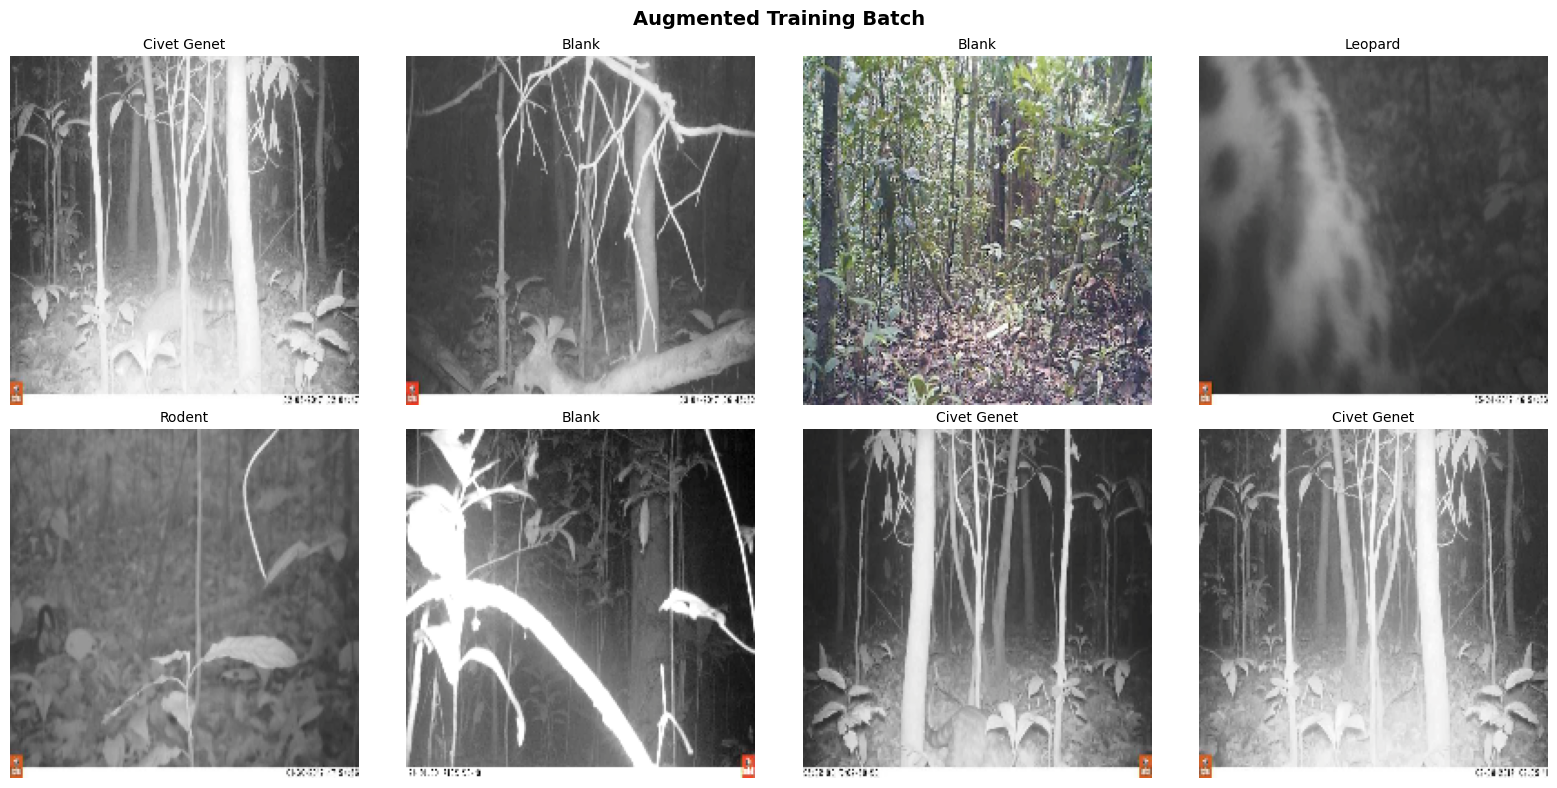

In [8]:
def visualize_batch(loader, num_images=8):
    """Visualize a batch of augmented images"""
    
    batch = next(iter(loader))
    images = batch['image'][:num_images]
    labels = batch['labels'][:num_images]
    
    # Denormalize images
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    images = images * std + mean
    images = torch.clamp(images, 0, 1)
    
    # Plot
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for idx, (img, label) in enumerate(zip(images, labels)):
        img_np = img.permute(1, 2, 0).numpy()
        axes[idx].imshow(img_np)
        
        # Get class name
        class_idx = torch.argmax(label).item()
        class_name = CLASS_COLUMNS[class_idx]
        axes[idx].set_title(f"{class_name.replace('_', ' ').title()}", fontsize=10)
        axes[idx].axis('off')
    
    plt.suptitle('Augmented Training Batch', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'visualizations' / 'augmented_batch.png', dpi=200)
    plt.show()

# Visualize training batch
print("Visualizing augmented training batch...")
visualize_batch(train_loader, num_images=8)

Comparing original vs augmented images...


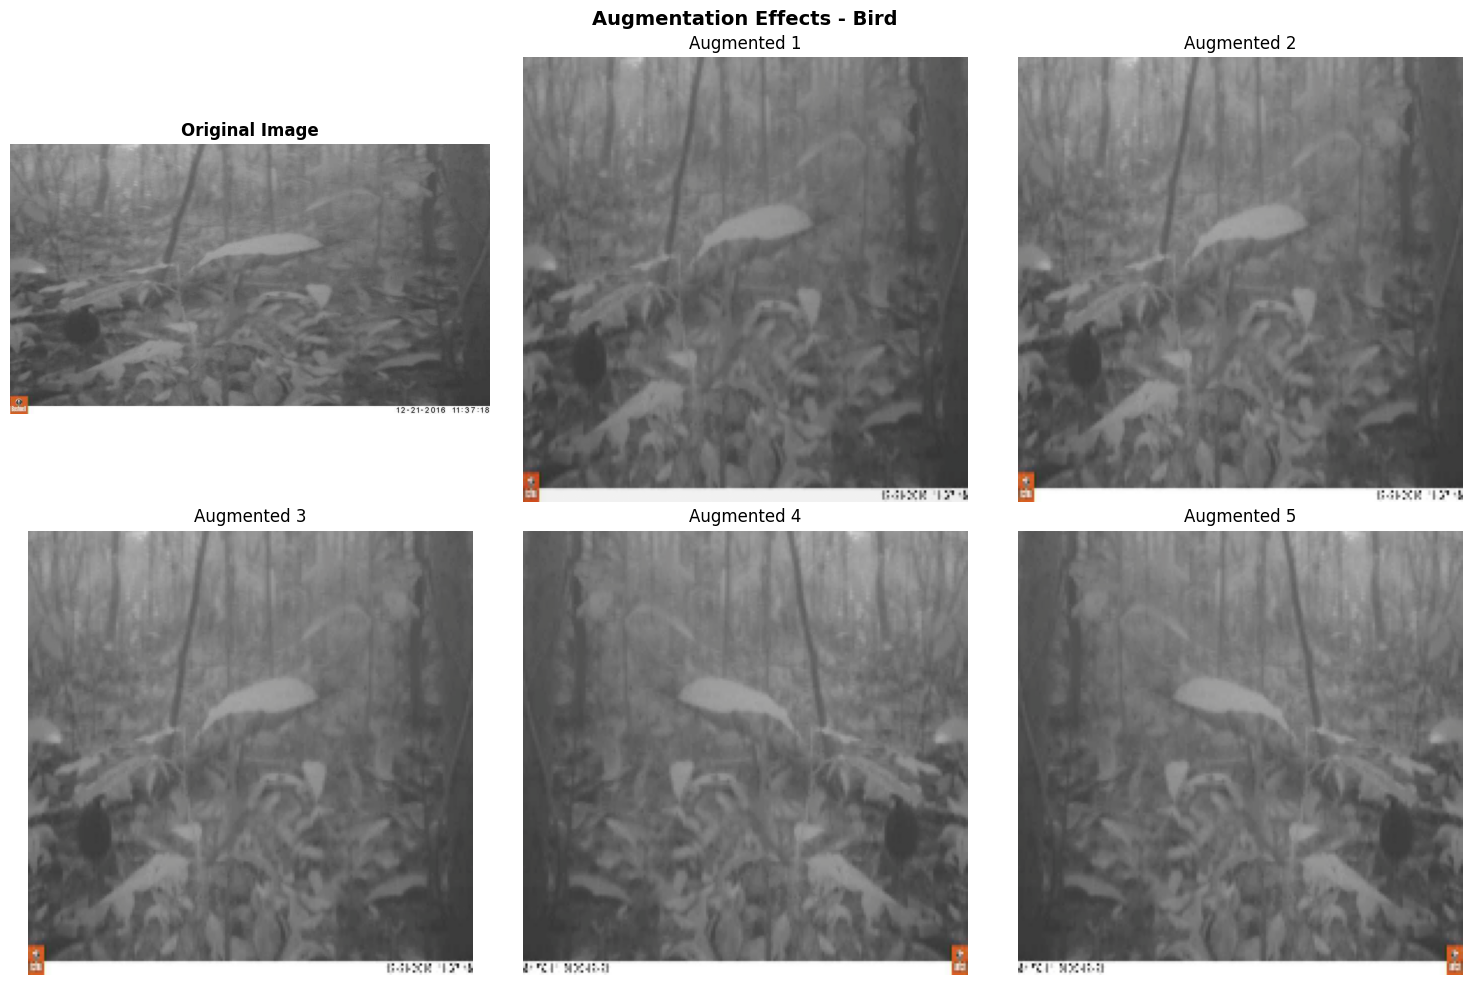

In [9]:
def show_augmentation_effects(dataset, idx=0, num_augmentations=6):
    """Show the same image with different augmentations"""
    
    # Get original image
    row = dataset.df.iloc[idx]
    img_path = dataset.data_dir / row['filepath']
    original_img = np.array(Image.open(img_path).convert('RGB'))
    
    # Get class name
    class_idx = np.argmax(row[CLASS_COLUMNS].values)
    class_name = CLASS_COLUMNS[class_idx]
    
    # Create figure
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    # Show original
    axes[0].imshow(original_img)
    axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Show augmented versions
    for i in range(1, num_augmentations):
        transformed = dataset.transform(image=original_img)
        img_tensor = transformed['image']
        
        # Denormalize
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img_denorm = img_tensor * std + mean
        img_denorm = torch.clamp(img_denorm, 0, 1)
        
        # Convert to numpy
        img_np = img_denorm.permute(1, 2, 0).numpy()
        
        axes[i].imshow(img_np)
        axes[i].set_title(f'Augmented {i}', fontsize=12)
        axes[i].axis('off')
    
    plt.suptitle(f'Augmentation Effects - {class_name.replace("_", " ").title()}', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Show augmentation effects
print("Comparing original vs augmented images...")
show_augmentation_effects(train_dataset, idx=0, num_augmentations=6)

In [10]:
# Load class weights from split info
with open(OUTPUT_DIR / 'split_info.json', 'r') as f:
    split_info = json.load(f)

class_weights = split_info['class_weights']

# Convert to tensor in correct order
class_weights_tensor = torch.tensor([class_weights[cls] for cls in CLASS_COLUMNS])

print("Class weights loaded:")
for cls, weight in zip(CLASS_COLUMNS, class_weights_tensor):
    print(f"   {cls:20s}: {weight:.4f}")

print(f"\n Class weights tensor shape: {class_weights_tensor.shape}")

Class weights loaded:
   antelope_duiker     : 0.8312
   bird                : 1.1734
   blank               : 0.9188
   civet_genet         : 0.7941
   hog                 : 1.8965
   leopard             : 1.0143
   monkey_prosimian    : 0.8724
   rodent              : 1.0668

 Class weights tensor shape: torch.Size([8])


In [11]:
def count_parameters(model):
    """Count trainable parameters in a model"""
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

def get_batch_info(loader):
    """Get information about a dataloader"""
    batch = next(iter(loader))
    return {
        'batch_size': batch['image'].shape[0],
        'image_shape': batch['image'].shape,
        'labels_shape': batch['labels'].shape,
        'num_batches': len(loader),
        'total_samples': len(loader.dataset)
    }

# Get dataloader info
train_info = get_batch_info(train_loader)
val_info = get_batch_info(val_loader)

print("DataLoader Information:")
print("\nTraining:")
for key, value in train_info.items():
    print(f"   {key}: {value}")

print("\nValidation:")
for key, value in val_info.items():
    print(f"   {key}: {value}")

/Users/gurjindersingh/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gurjindersingh/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


DataLoader Information:

Training:
   batch_size: 64
   image_shape: torch.Size([64, 3, 192, 192])
   labels_shape: torch.Size([64, 8])
   num_batches: 211
   total_samples: 13518

Validation:
   batch_size: 64
   image_shape: torch.Size([64, 3, 192, 192])
   labels_shape: torch.Size([64, 8])
   num_batches: 47
   total_samples: 2970


In [12]:
config = {
    'image_size': IMG_SIZE,
    'batch_size': BATCH_SIZE,
    'num_workers': NUM_WORKERS,
    'num_classes': len(CLASS_COLUMNS),
    'class_names': CLASS_COLUMNS,
    'normalization': {
        'mean': [0.485, 0.456, 0.406],
        'std': [0.229, 0.224, 0.225]
    },
    'augmentation': {
        'train': 'aggressive',
        'val': 'minimal',
        'techniques': [
            'horizontal_flip', 'vertical_flip', 'shift_scale_rotate',
            'random_crop', 'brightness_contrast', 'hue_saturation',
            'blur', 'noise', 'coarse_dropout'
        ]
    },
    'train_batches_per_epoch': len(train_loader),
    'val_batches_per_epoch': len(val_loader)
}

with open(OUTPUT_DIR / 'dataloader_config.json', 'w') as f:
    json.dump(config, f, indent=2)

print(" Configuration saved to:", OUTPUT_DIR / 'dataloader_config.json')

 Configuration saved to: outputs/dataloader_config.json


In [13]:
print("="*80)
print("DATALOADER SETUP COMPLETE!")
print("="*80)

print(f"\n Summary:")
print(f"   • Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"   • Batch size: {BATCH_SIZE}")
print(f"   • Training batches per epoch: {len(train_loader)}")
print(f"   • Validation batches per epoch: {len(val_loader)}")
print(f"   • Total training samples: {len(train_dataset)}")
print(f"   • Total validation samples: {len(val_dataset)}")
print(f"   • Classes: {len(CLASS_COLUMNS)}")

DATALOADER SETUP COMPLETE!

 Summary:
   • Image size: 192x192
   • Batch size: 64
   • Training batches per epoch: 211
   • Validation batches per epoch: 47
   • Total training samples: 13518
   • Total validation samples: 2970
   • Classes: 8
